In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data preparation: select data from the hand device

In [2]:
datadir = '../PAMAP2_Dataset/'

list_file = ['Protocol/subject101.dat',\
             'Protocol/subject102.dat',\
             'Protocol/subject103.dat',\
             'Protocol/subject104.dat',\
             'Protocol/subject105.dat',\
             'Protocol/subject106.dat',\
             'Protocol/subject107.dat',\
             'Protocol/subject108.dat',\
             'Protocol/subject109.dat']


Data from  inertial measurement units (IMU) at wrist, chest, and hanckle included in the dataset. 

* activityID (see below for the mapping to the activities) 
* heart rate (bpm) 
* temperature (C) , ** wrist IMU **
* 3D-acceleration data  ,** wrist IMU **
* 3D-magnetometer data  , ** wrist IMU **

In [3]:
features = [0,1,2,3,4,5,6,10,11,12]
data_labels = ['time',
               'activity', 
               'heart_rate', 
               'hand_temp',
               'ac_16g_x',
               'ac_16g_y',
               'ac_16g_z',
               'g_x',
               'g_y',
               'g_z']

In [4]:

lsub = []
isubject = 0
# Load remaining data files and concatenate with initial dataframe
for lfile in list_file:
    datafile = datadir+lfile
    isubject += 1
    
    df = pd.read_table(datafile,header=None,delim_whitespace=True)
    #print('Done reading data file ', datafile)
    #df.info()
    df = df[features]
    df.columns = data_labels
    df.loc[:,'subject'] = isubject
    df.loc[:,'intensity'] = df['activity'][:]
    df['heart_rate'].ffill(inplace=True)
    lsub.append(df)

In [5]:
target_labels = ['minimum','low','medium','high']
#
#
######################################################################
# Dictionary for the assign the activity intensity level
# to each of the 24 activities recorded
# 
conversion_dict = {'minimum':[1,2,3,9,10,11,18],
                   'low': [17,13,19],
                   'medium': [4,12,16],
                   'high':[5,6,7,20,24]}

lsub_level = []

for df_level in lsub:
    for tl in target_labels:
        lact = conversion_dict[tl]
        for iactivity in lact:
            #print(iactivity,tl,np.sum(df_level['activity'] == iactivity))
            df_level = df_level[df_level.activity != 0][:]
            
            df_level.loc[df_level['activity'] == iactivity,'intensity']=tl
            #dl_level= df_level[::20]
    lsub_level.append(df_level[::25])

In [6]:
    
df2 = pd.concat(lsub_level)

In [7]:
df2.loc[:,'ac_16g_norm']=df2[['ac_16g_x','ac_16g_y','ac_16g_z']].apply(lambda x: np.linalg.norm(x), axis=1)

In [8]:
df2.dropna(inplace=True)

In [9]:
##################################################################### 
# Prepare the target labels
#
intesity_labels = df2['intensity']
# 
# Extract the unique labels
labels = list(set(intesity_labels))
print("Unique intensity labels : ", labels)

# Prepare the array of labels for the machine learning data set
target_labels = np.array([labels.index(x) for x in intesity_labels])

# Prepare the array of target features for the machine learning data set
target_features = df2[['hand_temp','heart_rate','ac_16g_x','ac_16g_y','ac_16g_z','g_x','g_y','g_z']].as_matrix()

Unique intensity labels :  ['low', 'high', 'medium', 'minimum']


# Machine learning modeling

In [10]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.cross_validation import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [11]:
# Prepare train and test set for the machine learning step
X = target_features
y = target_labels

# Here I am using 20 % of the data set for test and 80 % for training the model
X_train, X_test, \
y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=33646)

## Classification via RF

In [12]:
clf = RandomForestClassifier()

In [13]:
# Run the ML model on the test set and determine prediction accuracy
#
clf.fit(X_train, y_train)
y_pred_rf = clf.predict(X_test)


confusion_matrix(y_test, y_pred_rf)

array([[3034,   38,  310,   91],
       [  45, 4767,   95,   16],
       [ 317,  133, 4735,   63],
       [ 165,    9,   83, 5421]])

In [14]:
print(classification_report(y_test, y_pred_rf))

             precision    recall  f1-score   support

          0       0.85      0.87      0.86      3473
          1       0.96      0.97      0.97      4923
          2       0.91      0.90      0.90      5248
          3       0.97      0.95      0.96      5678

avg / total       0.93      0.93      0.93     19322



## Classification via k-NN

In [15]:
clf_knn = KNeighborsClassifier(n_neighbors=8)
clf_knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=8, p=2,
           weights='uniform')

In [16]:
# Run the ML model on the test set and determine prediction accuracy
#
y_pred_knn = clf_knn.predict(X_test)


confusion_matrix(y_test, y_pred_knn)

array([[2715,  133,  367,  258],
       [  91, 4623,  184,   25],
       [ 457,  231, 4383,  177],
       [ 136,    8,   57, 5477]])

In [17]:
print(classification_report(y_test, y_pred_knn))

             precision    recall  f1-score   support

          0       0.80      0.78      0.79      3473
          1       0.93      0.94      0.93      4923
          2       0.88      0.84      0.86      5248
          3       0.92      0.96      0.94      5678

avg / total       0.89      0.89      0.89     19322



## Classification via gradient boosted trees

In [18]:
clf_gbt = GradientBoostingClassifier()
clf_gbt.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

In [19]:
# Run the ML model on the test set and determine prediction accuracy
#
y_pred_gbt = clf_gbt.predict(X_test)


confusion_matrix(y_test, y_pred_gbt)

array([[2761,  115,  417,  180],
       [  35, 4656,  181,   51],
       [ 282,  182, 4651,  133],
       [ 165,   22,  114, 5377]])

In [20]:
print(classification_report(y_test, y_pred_gbt))

             precision    recall  f1-score   support

          0       0.85      0.79      0.82      3473
          1       0.94      0.95      0.94      4923
          2       0.87      0.89      0.88      5248
          3       0.94      0.95      0.94      5678

avg / total       0.90      0.90      0.90     19322



## Visualization of results

In [21]:

result_select = (y_pred_rf == y_test)


y_correct = y_test[result_select]
X_correct = X_test[result_select,:]

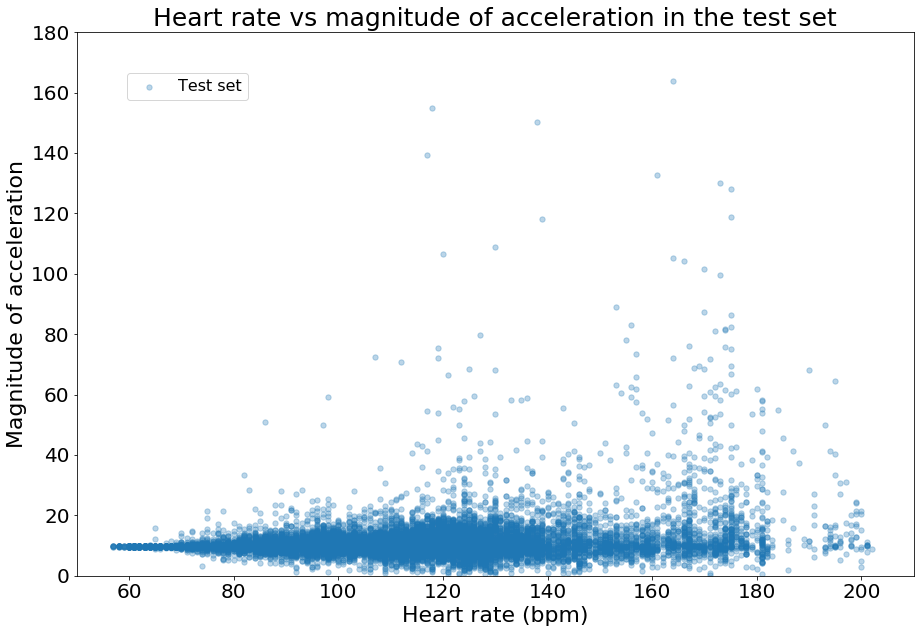

In [22]:
#########################################################################
# Plot of data set
#
# Here I plot the heart rate vs. the magnitude of acceleration vector for
# the points in the ML test set
#

fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(111,)

ax1.set_title('Heart rate vs magnitude of acceleration in the test set',fontsize=25)
ax1.set_xlabel('Heart rate (bpm)',fontsize=22)
ax1.set_ylabel('Magnitude of acceleration',fontsize=22)
#ax1.set_xticklabels(fontsize=12)
ax1.tick_params(labelsize=20)

#
# Prepare x and y data to plot
#
x_heart_rate_test = X_test[:,1]
y_acc_mag_test = np.linalg.norm(X_test[:,2:5],axis=1)

ax1.scatter(x_heart_rate_test,y_acc_mag_test, s=28, alpha=0.3,label='Test set')


lgd = plt.legend(loc='center left', bbox_to_anchor=(0.05, 0.90),fontsize = 16)
ax1.set_ylim(0,180)
ax1.set_xlim(50,210)


plt.show()

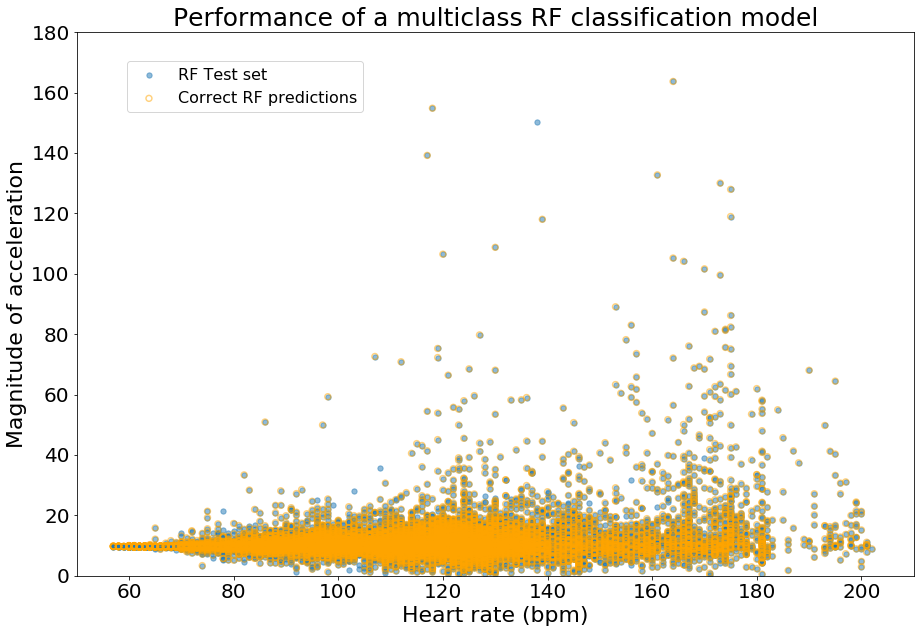

In [23]:
#########################################################################
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(111,)

ax1.set_title('Performance of a multiclass RF classification model',fontsize=25)

ax1.set_xlabel('Heart rate (bpm)',fontsize=22)
ax1.set_ylabel('Magnitude of acceleration',fontsize=22)
ax1.tick_params(labelsize=20)


#
# Prepare x and y data to plot
#
x_heart_rate_test = X_test[:,1]
x_heart_rate_correct = X_correct[:,1]

y_acc_mag_test = np.linalg.norm(X_test[:,2:5],axis=1)
y_acc_mag_correct = np.linalg.norm(X_correct[:,2:5],axis=1)

ax1.scatter(x_heart_rate_test,y_acc_mag_test, 
            s=28, alpha=0.5, label='RF Test set')

ax1.scatter(x_heart_rate_correct,y_acc_mag_correct, 
            linewidth = 1.5, facecolors='none',\
           edgecolor='orange', s=35, alpha=0.5,label='Correct RF predictions')


lgd = plt.legend(loc='center left', bbox_to_anchor=(0.05, 0.90),fontsize = 16)
ax1.set_ylim(0,180)
ax1.set_xlim(50,210)


plt.show()